In [1]:
#Import required packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

In [63]:
def format_date(df_date):
    """
    Splits Meeting Times and Dates into datetime objects where applicable using regex.
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Year'] = df_date['Term'].astype(str).str.slice(0,4)
    df_date['Quarter'] = df_date['Term'].astype(str).str.slice(4,6)
    df_date['Term_Date'] = pd.to_datetime(df_date['Year'] + df_date['Quarter'], format='%Y%m')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    #df_date['End_Month'] = pd.to_datetime(df_date['End_Date'], format='%b')
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    df_date = df_date.set_index(pd.DatetimeIndex(df_date['Term_Date']))
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl


def grouped_plot_graph(df_in):
    fig, ax = plt.subplots()
    grouped = df_in.groupby(['Year', 'Quarter'])
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Start_Month', y='Cap_Diff', label=key)
    plt.show()
    
def plot_graph(x_vals, y_vals):
    """
    Plots the dataframe information.
    """
    x = range(len(x_vals))
    plt.figure(figsize=(20,10)) 
    N = 50
    colors = np.random.rand(N)
    sns.stripplot(x_vals, y_vals)
    plt.xticks(rotation=90)
    #plt.scatter(x, y_vals, alpha=0.5, )
    plt.show()

def OLS_operations(y, X):
    #mod = smf.OLS('Cap_Diff ~ C(Dept)', data=df_data)
    mod = sm.OLS(np.asarray(y), X)
    res = mod.fit()
    print(res.summary())
    fig = plt.figure(figsize=(20,10))
    fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
    plt.show()
    
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, center=False,window=4).mean()
    rolstd = pd.Series.rolling(timeseries, center=False,window=4).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
def main():
    """
    Main program control flow.
    """
    #pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    df = pd.read_csv('data/PSU_master_classroom.csv')
    df = df.fillna('')

    df = format_date(df)
    # Avoid classes that only occur on a single day
    df = df.loc[df['Start_Date'] != df['End_Date']]
    df = df.loc[df['Online Instruct Method'] != 'Fully Online']
    
    # Calculate number of days per week and treat Sunday condition
    df['Days_Per_Week'] = df['Days'].str.len()
    df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
    
    df_cl = format_xlist(df)
    df_cl = df_cl.groupby('Term_Date').sum()
    test_stationarity(df_cl['Cap_Diff'])
    
    ts_log = np.log(df_cl['Cap_Diff'])
    moving_avg = pd.Series.rolling(ts_log, center=False,window=4).mean()
    """
    plt.plot(ts_log)
    plt.plot(moving_avg, color='red')
    """
    expwighted_avg = pd.Series.ewm(ts_log, halflife=4,ignore_na=False,adjust=True,min_periods=0).mean()
    plt.plot(ts_log)
    plt.plot(expwighted_avg, color='red')
    ts_log_ewma_diff = ts_log - expwighted_avg
    plt.show()

    test_stationarity(ts_log_ewma_diff)



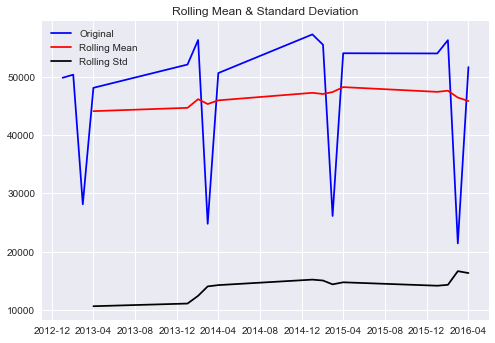

Results of Dickey-Fuller Test:
Test Statistic                -0.814461
p-value                        0.814837
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (5%)           -3.289881
Critical Value (1%)           -4.473135
Critical Value (10%)          -2.772382
dtype: float64


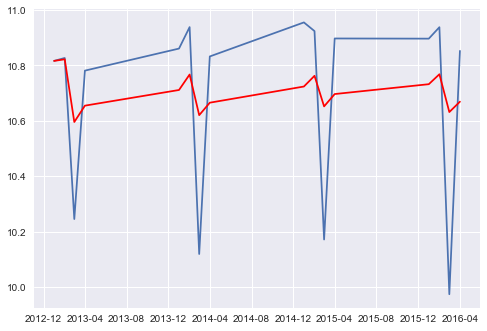

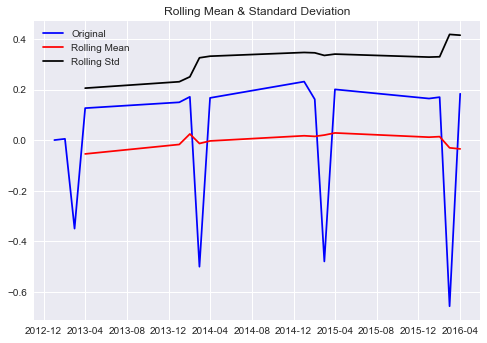

Results of Dickey-Fuller Test:
Test Statistic                -0.649233
p-value                        0.859465
#Lags Used                     6.000000
Number of Observations Used    9.000000
Critical Value (5%)           -3.289881
Critical Value (1%)           -4.473135
Critical Value (10%)          -2.772382
dtype: float64


In [64]:
main()